- Load Library

In [1]:
import pandas as pd
from symspellpy.symspellpy import SymSpell, Verbosity
import re
from tabulate import tabulate 
from spellchecker import SpellChecker
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy
from nltk.corpus import stopwords
from datetime import datetime
import nltk
import string
import emoji
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JohnTan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

- Load Combined Twitter News Topic Dataset

In [2]:
# Load the datasets
mergedA_df = pd.read_csv("Dataset\\merged_datasetA.csv")

# Display first few rows
print(mergedA_df.head(7))
print( len(mergedA_df))


                                                text  label
0  Here are Thursday's biggest analyst calls: App...      0
1  Buy Las Vegas Sands as travel to Singapore bui...      0
2  Piper Sandler downgrades DocuSign to sell, cit...      0
3  Analysts react to Tesla's latest earnings, bre...      0
4  Netflix and its peers are set for a ‘return to...      0
5  Barclays believes earnings for these underperf...      0
6  Bernstein upgrades Alibaba, says shares can ra...      0
21107


- EDA of Combined Twitter News Topic Dataset

In [3]:
# Overview of the data structure
print("Shape:", mergedA_df.shape)
print("\nInfo:")
print(mergedA_df.info())
print("\nMissing values:\n", mergedA_df.isnull().sum())
print("\nDuplicate rows:", mergedA_df.duplicated().sum())

Shape: (21107, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21107 entries, 0 to 21106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21107 non-null  object
 1   label   21107 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.9+ KB
None

Missing values:
 text     0
label    0
dtype: int64

Duplicate rows: 0


In [ ]:
#Descriptive Analysis
def print_stats(stats_df, title):
    print(f"\n{title} Statistics:")
    print("="*50)
    print(stats_df.to_markdown(tablefmt="grid", stralign='center', numalign='center'))
    print("="*50)


mergedA_df["length"] = mergedA_df["text"].apply(lambda x: len(x.split()))
grouped_stats = mergedA_df.groupby('label')["length"].agg(['max', 'min', 'mean', 'median', 'std', 'count'])
print_stats(grouped_stats, "Text Length per Label")


Text Length per Label Statistics:
+---------+-------+-------+---------+----------+---------+---------+
|  label  |  max  |  min  |  mean   |  median  |   std   |  count  |
+=========+=======+=======+=========+==========+=========+=========+
|    0    |  48   |   8   | 16.6159 |    15    | 6.61793 |   328   |
+---------+-------+-------+---------+----------+---------+---------+
|    1    |  53   |   6   | 22.3987 |    22    | 9.25974 |  1051   |
+---------+-------+-------+---------+----------+---------+---------+
|    2    |  51   |   2   | 16.5597 |    15    | 6.60992 |  4397   |
+---------+-------+-------+---------+----------+---------+---------+
|    3    |  47   |   4   | 18.1608 |    16    | 9.19502 |   398   |
+---------+-------+-------+---------+----------+---------+---------+
|    4    |  32   |   5   | 10.9013 |    10    | 3.83121 |   456   |
+---------+-------+-------+---------+----------+---------+---------+
|    5    |  52   |   3   | 15.6664 |    15    | 5.99153 |  1229   |

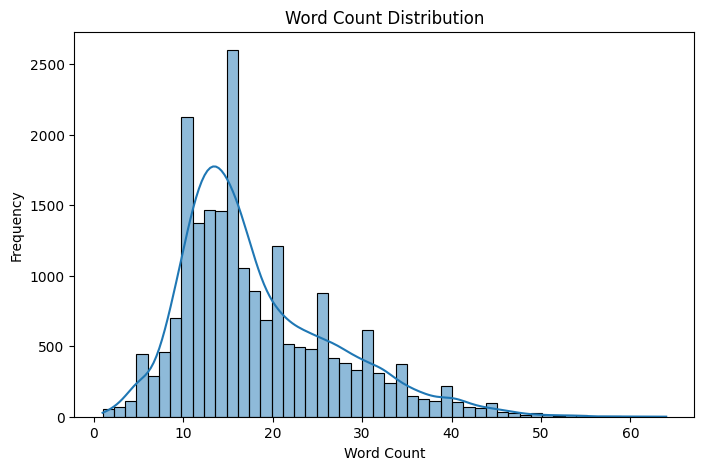

In [ ]:
# Statistic Report
# Word Length Distribution
mergedA_df['word_count'] = mergedA_df['text'].apply(lambda x: len(str(x).split()))
mergedA_df['char_count'] = mergedA_df['text'].apply(lambda x: len(str(x)))

plt.figure(figsize=(8,5))
sns.histplot(mergedA_df['word_count'], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


Top 5 Words:
+-----------+-------------+
| Word      |   Frequency |
+===========+=============+
| new       |        1329 |
+-----------+-------------+
| earnings  |        1049 |
+-----------+-------------+
| us        |         911 |
+-----------+-------------+
| announces |         841 |
+-----------+-------------+
| inflation |         831 |
+-----------+-------------+


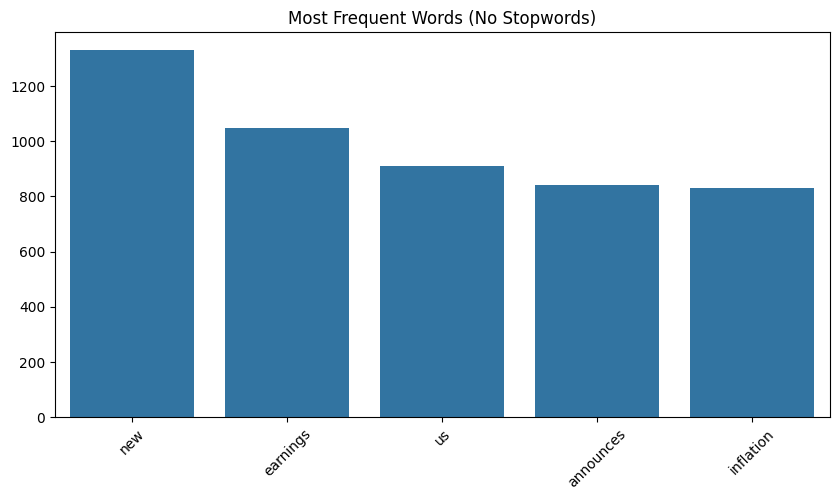

In [8]:
# Most Frequent Word
stop_words = set(stopwords.words('english'))
all_words = " ".join(mergedA_df['text']).split()
filtered_words = [w.lower() for w in all_words if w.lower() not in stop_words and w.isalpha()]

common_words = Counter(filtered_words).most_common(5)
word_table = [(word, freq) for word, freq in common_words]
print("\nTop 5 Words:")
print(tabulate(word_table, headers=["Word", "Frequency"], tablefmt="grid"))


# Plot
plt.figure(figsize=(10,5))
sns.barplot(x=[w[0] for w in common_words], y=[w[1] for w in common_words])
plt.xticks(rotation=45)
plt.title("Most Frequent Words (No Stopwords)")
plt.show()

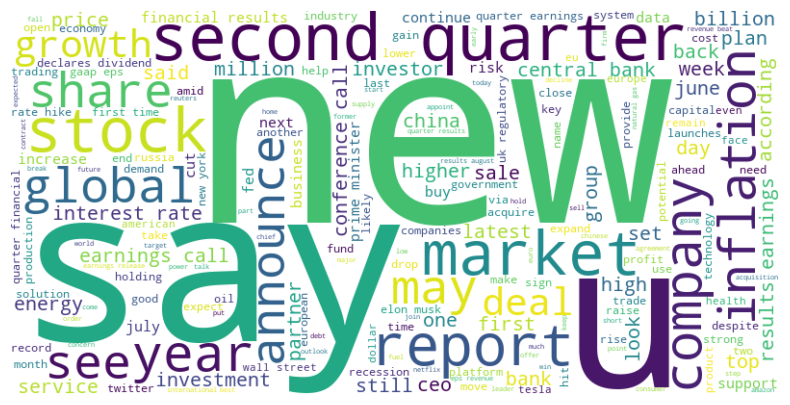

In [9]:
# Wordcloud
wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
# Detech Financial Ticker and Acronym
tickers = mergedA_df['text'].apply(lambda x: re.findall(r'\b[A-Z]{2,5}\b', str(x)))
all_tickers = Counter([t for sub in tickers for t in sub])

ticker_table  = [(ticker, freq) for ticker, freq in all_tickers.most_common(5)]
print("\nTop 5 Tickers/Acronyms:")
print(tabulate(ticker_table, headers=["Tickers/Acronyms", "Frequency"], tablefmt="grid"))



Top 5 Tickers/Acronyms:
+--------------------+-------------+
| Tickers/Acronyms   |   Frequency |
+====================+=============+
| US                 |         938 |
+--------------------+-------------+
| UK                 |         634 |
+--------------------+-------------+
| CEO                |         440 |
+--------------------+-------------+
| TO                 |         379 |
+--------------------+-------------+
| EPS                |         349 |
+--------------------+-------------+


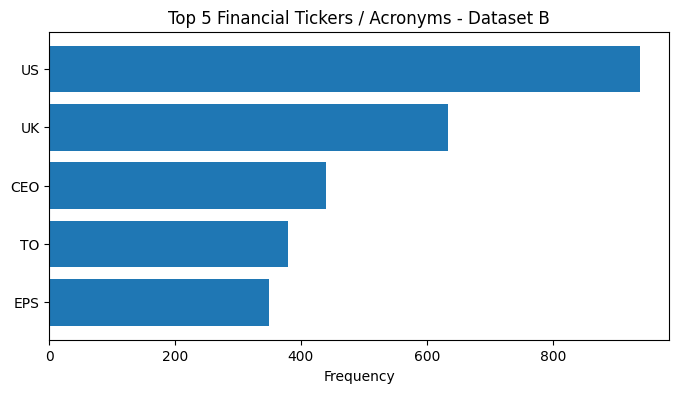

In [5]:
def plot_top_tickers(df, text_column, title):
    # Extract tickers
    tickers = df[text_column].apply(lambda x: re.findall(r'\b[A-Z]{2,5}\b', str(x)))
    all_tickers = Counter([t for sub in tickers for t in sub])
    top5 = all_tickers.most_common(5)

    # Separate keys and values
    labels = [x[0] for x in top5]
    counts = [x[1] for x in top5]

    # Plot
    plt.figure(figsize=(8, 4))
    plt.barh(labels, counts)
    plt.xlabel("Frequency")
    plt.title(f"Top 5 Financial Tickers / Acronyms - {title}")
    plt.gca().invert_yaxis()  # Highest at the top
    plt.show()
# Dataset B
plot_top_tickers(mergedA_df, 'text', "Dataset B")


In [9]:
# Mispelled Words Frequent
spell = SpellChecker()

# Count frequency of all words
word_freq = Counter(filtered_words)

# Find misspelled words
words = set(filtered_words)
misspelled = spell.unknown(words)


misspelled_counts = Counter([w for w in filtered_words if w in misspelled])
top_misspelled = misspelled_counts.most_common(5)

print(f"\nTotal Misspelled Words Found: {len(misspelled)}\n")
print("Top 5 Misspelled Words:")
print(tabulate(top_misspelled, headers=["Word", "Frequency"], tablefmt="grid"))


Total Misspelled Words Found: 5502

Top 5 Misspelled Words:
+--------+-------------+
| Word   |   Frequency |
+========+=============+
| uk     |         562 |
+--------+-------------+
| ceo    |         407 |
+--------+-------------+
| eps    |         329 |
+--------+-------------+
| elon   |         239 |
+--------+-------------+
| crypto |         219 |
+--------+-------------+


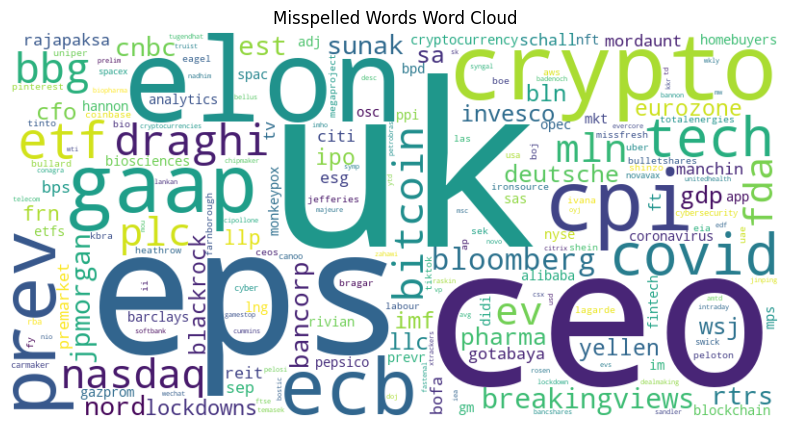

In [14]:
def plot_misspelled_wordcloud(misspelled_counts, title="Misspelled Words Word Cloud"):
    wc = WordCloud(width=800, height=400,
                   background_color='white').generate_from_frequencies(misspelled_counts)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_misspelled_wordcloud(misspelled_counts)


In [16]:
#Count Punctuation
def punctuation_stats(texts, top_n=5):
    all_text = " ".join(texts)
    punctuations = [char for char in all_text if char in string.punctuation]
    punct_count = len(punctuations)
    punct_freq = Counter(punctuations).most_common(top_n)
    return punct_count, punct_freq

total_punct, punct_freq = punctuation_stats(mergedA_df['text'], top_n=5)

# Print summary
print(f"\nTotal Punctuation Characters: {total_punct}")


print("\nTop 5 Punctuation Marks:")
print(tabulate(punct_freq, headers=["Punctuation", "Frequency"], tablefmt="grid"))


Total Punctuation Characters: 197378

Top 5 Punctuation Marks:
+---------------+-------------+
| Punctuation   |   Frequency |
+===============+=============+
| /             |       72129 |
+---------------+-------------+
| .             |       39074 |
+---------------+-------------+
| :             |       29026 |
+---------------+-------------+
| $             |       13931 |
+---------------+-------------+
| -             |       11579 |
+---------------+-------------+


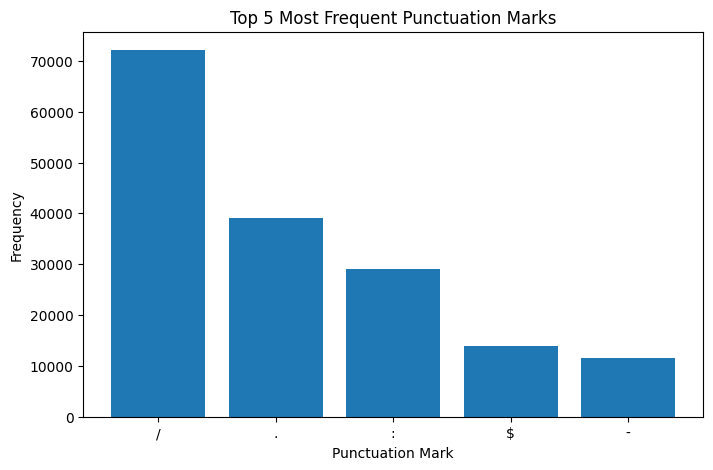

In [20]:
# Count ALL punctuation characters
def get_punct_freq(texts, top_n=5):
    all_text = " ".join(texts)
    punct_list = [char for char in all_text if char in string.punctuation]
    punct_counts = Counter(punct_list).most_common(top_n)
    return punct_counts

# Get top 5 punctuation marks
punct_freq = get_punct_freq(mergedA_df['text'], top_n=5)

# Prepare data
puncts = [p[0] for p in punct_freq]
counts = [p[1] for p in punct_freq]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(puncts, counts)
plt.xlabel("Punctuation Mark")
plt.ylabel("Frequency")
plt.title("Top 5 Most Frequent Punctuation Marks")
plt.show()


In [21]:
#Count Emoji
def emoji_stats(texts, top_n=5):
    all_text = " ".join(texts)
    emojis = [char for char in all_text if char in emoji.EMOJI_DATA]
    emoji_count = len(emojis)
    emoji_freq = Counter(emojis).most_common(top_n)
    return emoji_count, emoji_freq

total_emoji, emoji_freq = emoji_stats(mergedA_df['text'], top_n=5)

# Print summary
print(f"\nTotal Emojis: {total_emoji}")

# Show table of top emojis
print("\nTop 5 Emojis:")
print(tabulate(emoji_freq, headers=["Emoji", "Frequency"], tablefmt="grid"))


Total Emojis: 683

Top 5 Emojis:
+---------+-------------+
| Emoji   |   Frequency |
+=========+=============+
| ⬇       |         104 |
+---------+-------------+
| ®       |         101 |
+---------+-------------+
| 🚨      |          68 |
+---------+-------------+
| ™       |          65 |
+---------+-------------+
| 👇      |          25 |
+---------+-------------+


In [27]:
#Count contraction
def contraction_stats(texts, top_n=5):
    contraction_pattern = r"\b(?:[A-Za-z]+['’][A-Za-z]+)\b"
    all_text = " ".join(texts)
    contractions_found = re.findall(contraction_pattern, all_text)
    contraction_count = len(contractions_found)
    contraction_freq = Counter(contractions_found).most_common(top_n)
    return contraction_count, contraction_freq

total_contractions, contraction_freq = contraction_stats(mergedA_df['text'], top_n=5)
print(f"\nTotal Contractions: {total_contractions}")
print("\nTop 5 Contractions:")
print(tabulate(contraction_freq, headers=["Contraction", "Frequency"], tablefmt="grid"))


Total Contractions: 5227

Top 5 Contractions:
+---------------+-------------+
| Contraction   |   Frequency |
+===============+=============+
| China’s       |         183 |
+---------------+-------------+
| Here's        |         107 |
+---------------+-------------+
| it’s          |          97 |
+---------------+-------------+
| world’s       |          84 |
+---------------+-------------+
| Russia’s      |          83 |
+---------------+-------------+


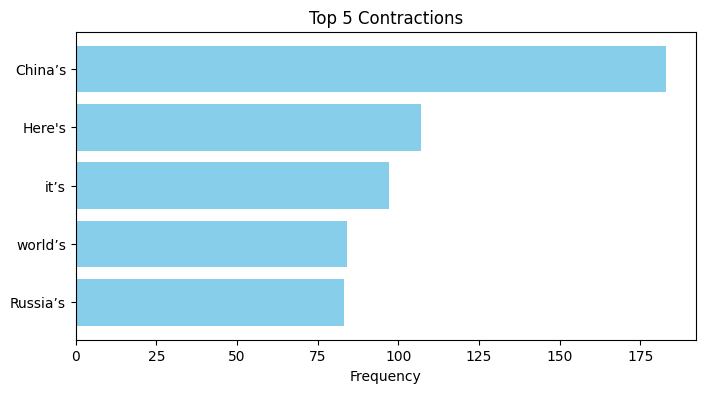

In [28]:
def plot_top_contractions(contraction_freq, title="Top 5 Contractions"):
    contractions = [x[0] for x in contraction_freq]
    counts = [x[1] for x in contraction_freq]

    plt.figure(figsize=(8, 4))
    plt.barh(contractions, counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.title(title)
    plt.gca().invert_yaxis()  # Highest frequency on top
    plt.show()

plot_top_contractions(contraction_freq)


In [29]:
#Count URL
def url_stats(texts, top_n=5):
    url_pattern = r"(https?://\S+|www\.\S+)"
    all_text = " ".join(texts)
    urls_found = re.findall(url_pattern, all_text)
    url_count = len(urls_found)
    url_freq = Counter(urls_found).most_common(top_n)
    return url_count, url_freq

total_urls, url_freq = url_stats(mergedA_df['text'], top_n=5)
print(f"\nTotal URLs: {total_urls}")
print("\nTop 5 URLs:")
print(tabulate(url_freq, headers=["URL", "Frequency"], tablefmt="grid"))


Total URLs: 23770

Top 5 URLs:
+-------------------------+-------------+
| URL                     |   Frequency |
+=========================+=============+
| https://t.co/LzEmmlQJhI |          68 |
+-------------------------+-------------+
| https://t.co/guyiBzPH8C |          46 |
+-------------------------+-------------+
| https://t.co/yChRCoaR8v |          22 |
+-------------------------+-------------+
| https://t.co/LzEmmm8k9g |          22 |
+-------------------------+-------------+
| https://t.co/3shkT8X95y |          21 |
+-------------------------+-------------+


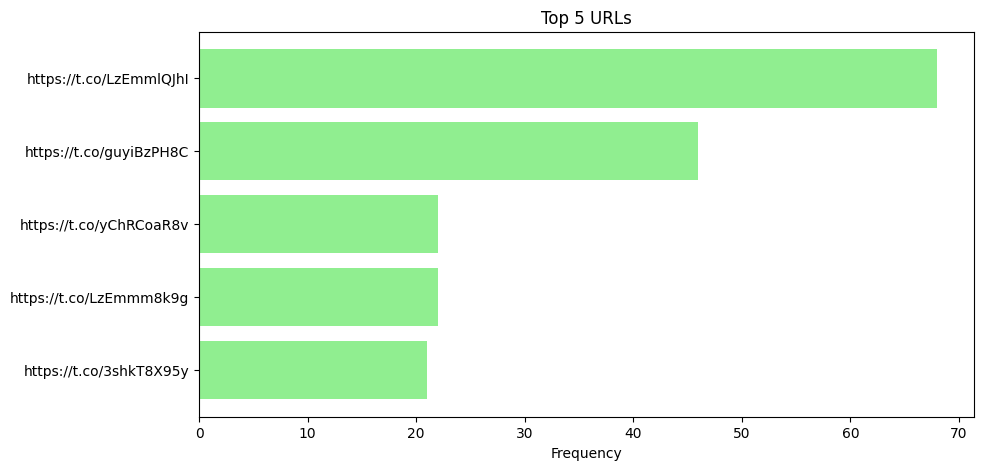

In [ ]:
def plot_top_urls(url_freq, title="Top 5 URLs"):
    urls = [x[0] for x in url_freq]
    counts = [x[1] for x in url_freq]

    plt.figure(figsize=(10, 5))
    plt.barh(urls, counts, color='lightgreen')
    plt.xlabel("Frequency")
    plt.title(title)
    plt.gca().invert_yaxis()  # Most frequent on top
    plt.show()

plot_top_urls(url_freq)


In [11]:
# Bigram and Trigram Analysis
from nltk import ngrams

def get_top_ngrams(corpus, n=None, gram_size=2):
    vec = [tuple(gram) for sentence in corpus for gram in ngrams(sentence.split(), gram_size)]
    return Counter(vec).most_common(n)

top_bigrams = get_top_ngrams(mergedA_df['text'], n=5, gram_size=2)
top_trigrams = get_top_ngrams(mergedA_df['text'], n=5, gram_size=3)

# Bigram table
bigram_table = [(" ".join(bigram), freq) for bigram, freq in top_bigrams]
print("\nTop 5 Bigrams:")
print(tabulate(bigram_table, headers=["Bigram", "Frequency"], tablefmt="grid"))

# Trigram table
trigram_table = [(" ".join(trigram), freq) for trigram, freq in top_trigrams]
print("\nTop 5 Trigrams:")
print(tabulate(trigram_table, headers=["Trigram", "Frequency"], tablefmt="grid"))


Top 5 Bigrams:
+----------------+-------------+
| Bigram         |   Frequency |
+================+=============+
| in the         |         998 |
+----------------+-------------+
| of the         |         923 |
+----------------+-------------+
| for the        |         581 |
+----------------+-------------+
| Second Quarter |         493 |
+----------------+-------------+
| to the         |         437 |
+----------------+-------------+

Top 5 Trigrams:
+------------------------+-------------+
| Trigram                |   Frequency |
+========================+=============+
| Second Quarter 2022    |         400 |
+------------------------+-------------+
| Results - Earnings     |         256 |
+------------------------+-------------+
| - Earnings Call        |         256 |
+------------------------+-------------+
| 2022 Financial Results |         163 |
+------------------------+-------------+
| GAAP EPS of            |         158 |
+------------------------+-------------+
